In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, work)
from illustris_sim import IllustrisSim
import corrfunc_ls

#### galaxy autocorrelations

In [4]:
zs = [1.5, 1., 0.5, 0.2, 0.1, 0.]

In [18]:
sims = []
for i, z in enumerate(zs):
    # initialize simulation and snapshot
    sim = IllustrisSim('TNG300-3', redshift=z)
    sim.load_galaxies(prints=True)
    sims.append(sim)

TNG300-3, z=1.50: loaded 1750 subhalos with > 100 stars and star mass > 0
TNG300-3, z=1.00: loaded 2814 subhalos with > 100 stars and star mass > 0
TNG300-3, z=0.50: loaded 3885 subhalos with > 100 stars and star mass > 0
TNG300-3, z=0.20: loaded 4307 subhalos with > 100 stars and star mass > 0
TNG300-3, z=0.10: loaded 4340 subhalos with > 100 stars and star mass > 0
TNG300-3, z=0.00: loaded 4389 subhalos with > 100 stars and star mass > 0


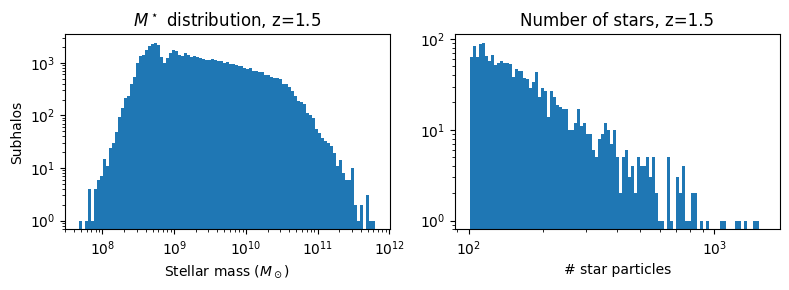

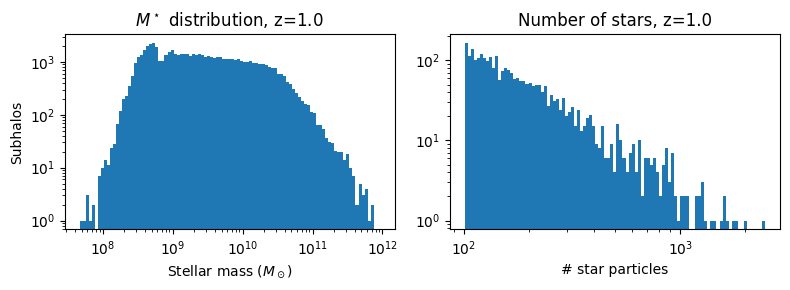

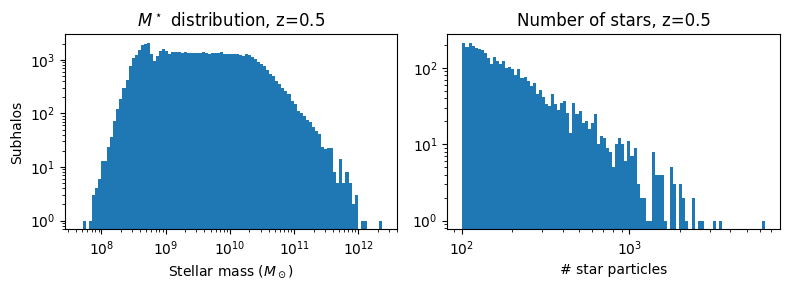

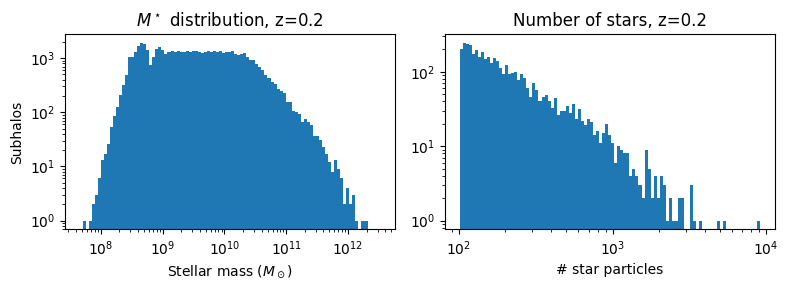

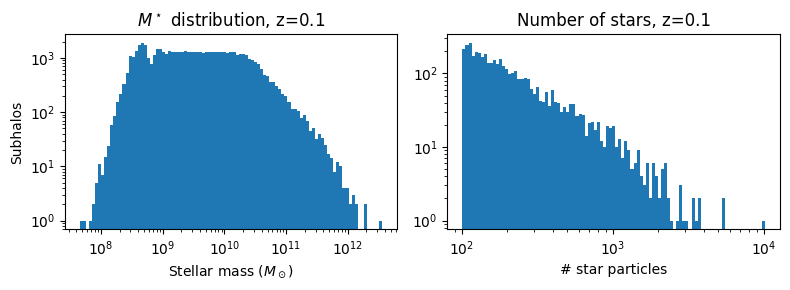

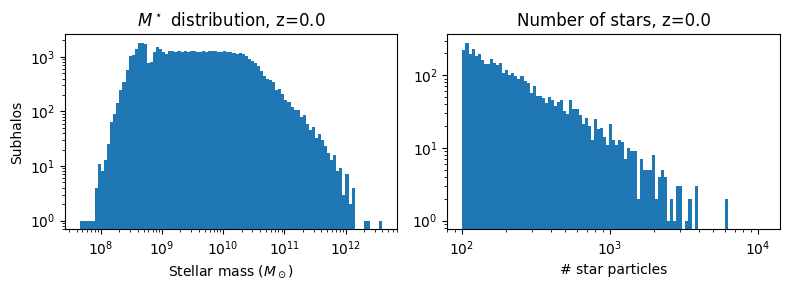

In [26]:
for i, sim in enumerate(sims):
    # stellar mass distribution
    sim.load_stellar_mass()
    stellar_mass = sim.stellar_mass[sim.stellar_mass.value>0] # get only nonzero stellar masses
    
    # number of stars
    nstars = sim.gal_len_types[:,4]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
    
    nbins = 100

    bins = np.logspace(np.log10(min(stellar_mass.value)), np.log10(max(stellar_mass.value)), nbins)
    _, _, _ = ax1.hist(stellar_mass.value, bins=bins)
    
    ax1.set_xlabel(f'Stellar mass ($M_\odot$)')
    ax1.set_title(f'$M^\star$ distribution, z={sim.redshift}')
    ax1.set_ylabel('Subhalos')
    
    bins = np.logspace(np.log10(min(nstars)), np.log10(max(nstars)), nbins)
    _, _, _ = ax2.hist(nstars, bins=bins)
    
    ax2.set_xlabel(f'# star particles')
    ax2.set_title(f'Number of stars, z={sim.redshift}')
    
    for ax in [ax1, ax2]:
        ax.set_xscale('log')
        ax.set_yscale('log')
    fig.tight_layout()

#### compute Gal x Gal

In [27]:
# parameters
randmult = 3
rmin = 0.1
rmax = 50.
nbins = 20
nthreads = 12
print(rmin, rmax, nbins)

0.1 50.0 20


In [28]:
%%time
nrepeats = 10
xi_galss = np.empty((len(zs),nbins))
for i, sim in enumerate(sims):
    xi_gals = np.empty((nrepeats, nbins))
    for j in range(nrepeats):
        ravg, xi_gals[j] = corrfunc_ls.compute_3D_ls_auto(sim.gal_pos.value, randmult, rmin, rmax,
                                            nbins, logbins=True, periodic=True, nthreads=nthreads, prints=False)
    xi_galss[i] = np.mean(xi_gals, axis=0)

CPU times: user 33.6 s, sys: 164 ms, total: 33.7 s
Wall time: 3.65 s


In [29]:
cnorm = mpl.colors.Normalize(vmin=min(zs), vmax=max(zs))
smap = mpl.cm.ScalarMappable(norm=cnorm, cmap='cool')

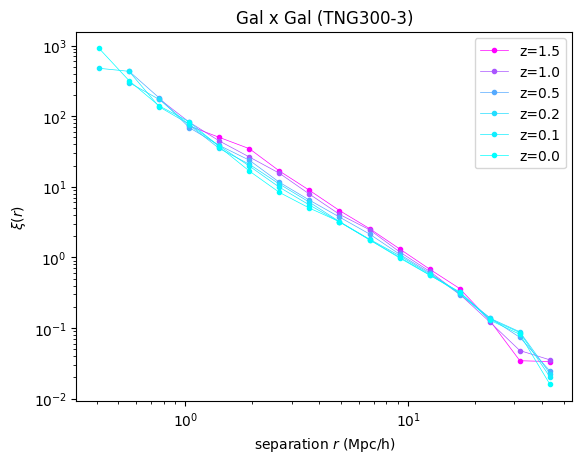

In [30]:
fig, ax = plt.subplots()

for i, z in enumerate(zs):
    ax.plot(ravg, xi_galss[i], marker='.', lw=0.5, color=smap.to_rgba(z), label=f'z={z}')
# ax.plot(xi_dm_auto['ravg'], xi_dm_auto['xi'], 'k.-', lw=0.5, label='DM x DM (1/10th subsample)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title(f'Gal x Gal ({sim.sim})')
ax.legend()